In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## PCA (Principle Component Analysis)

### Load the breast cancer dataset

In [410]:
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
X = breast.data
y = breast.target
X.shape

(569, 30)

### Normalize the data

In [412]:
X = StandardScaler().fit_transform(X)

### Run the PCA analysis

In [419]:
pca_breast = PCA(n_components=10)
pcs = pca_breast.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_))

Explained variation per principal component: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]


### Visualize the data using only 2 PCs

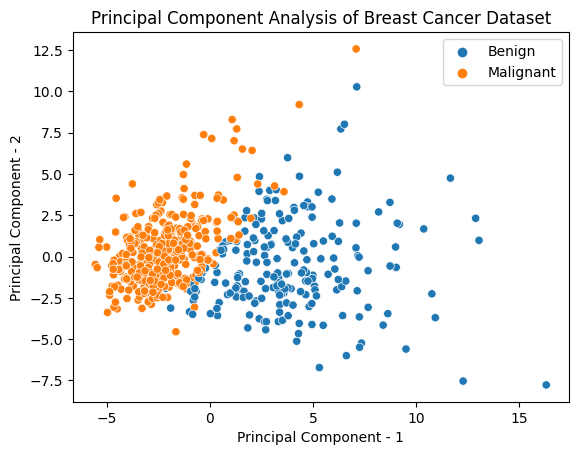

In [433]:
plt.figure()
targets = np.array(['Benign', 'Malignant'])
colors = {'Benign': 'tab:blue', 'Malignant': 'tab:red'}
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], hue=targets[y])
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title("Principal Component Analysis of Breast Cancer Dataset")
plt.show()

## SVD (Singular Value Decomposition)

### Load the LFW dataset (Labeled Faces in the Wild - https://vis-www.cs.umass.edu/lfw) 

In [293]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=110)
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_samples, n_features = X.shape
print(f'Number of observations: {n_samples}')
print(f'Number of features: {n_features}')

Number of observations: 1031
Number of features: 2914


### Face Example

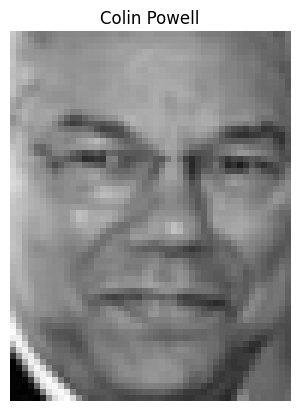

In [310]:
face_example = X[0, :].reshape((lfw_dataset.images.shape[1], lfw_dataset.images.shape[2]))
plt.imshow(face_example, cmap='gray')
plt.title(target_names[y[0]])
plt.axis('off')
plt.show()

### Calculate the SVD

In [295]:
# Compute the mean face
mean_face = np.mean(X, axis=0)

# Subtract the mean face from the data
X_centered = X - mean_face

# Perform SVD on the centered data
U, S, Vt = np.linalg.svd(X_centered, full_matrices=True)
print(f'U: {U.shape}')
print(f'S: {S.shape}')
print(f'Vt: {Vt.shape}')

U: (1031, 1031)
S: (1031,)
Vt: (2914, 2914)


### Visualize the Eigenfaces

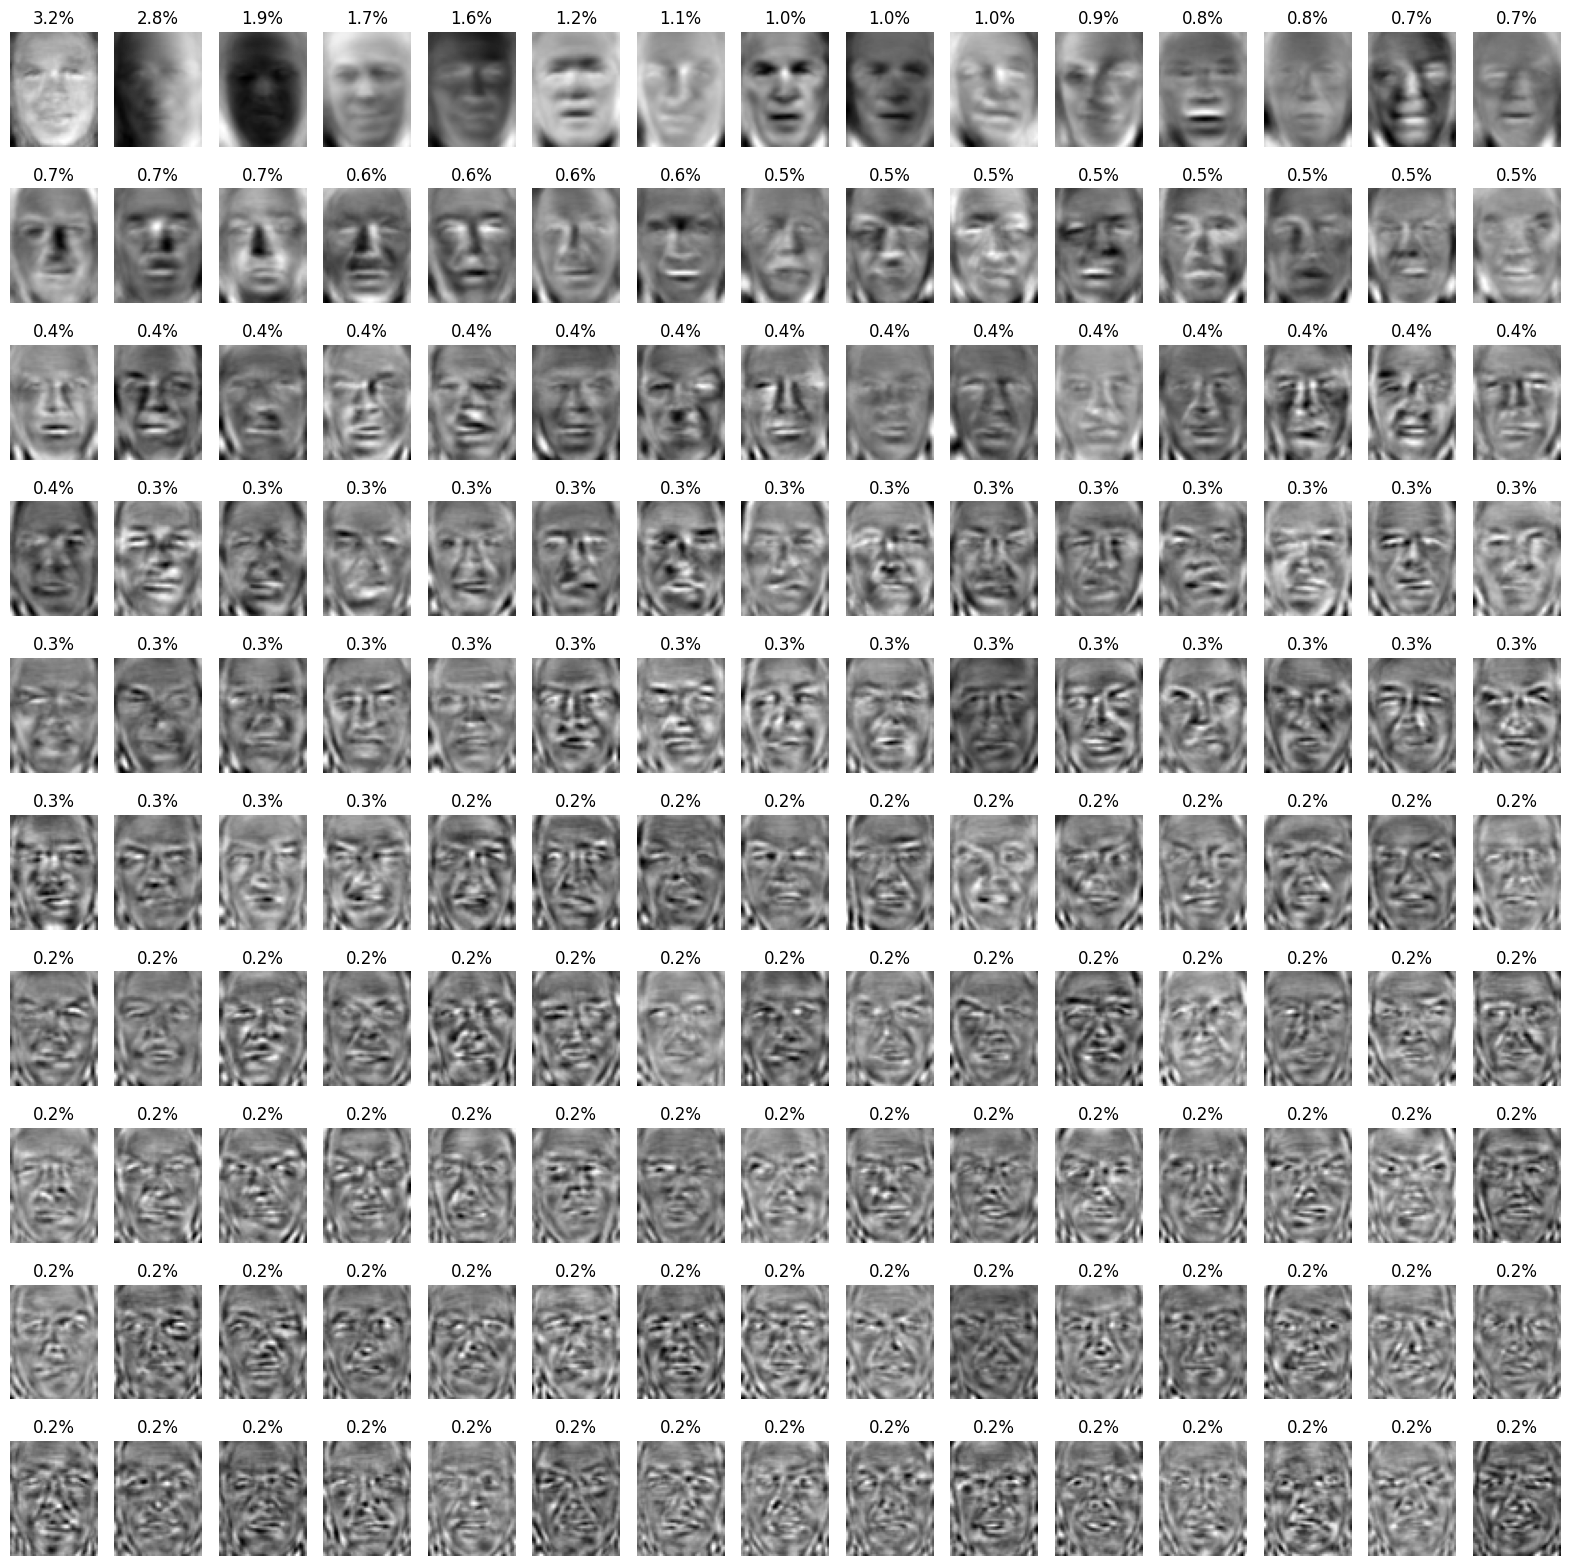

In [316]:
n_components = 150
eigenfaces = Vt[:n_components].reshape((n_components, lfw_dataset.images.shape[1], lfw_dataset.images.shape[2]))

cols = 15
rows = int(np.ceil(n_components/cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows))
axes = axes.flatten()
for i in range(n_components):
    axes[i].imshow(eigenfaces[i], cmap='gray')
    axes[i].set_title(f'{S[i]/S.sum():.1%}')
    axes[i].axis('off')
plt.show()

### Projecting the faces to the eigenfaces basis

In [317]:
proj_faces = np.matmul(X_centered, Vt[:, :n_components])
proj_faces.shape

(1031, 150)

<AxesSubplot:>

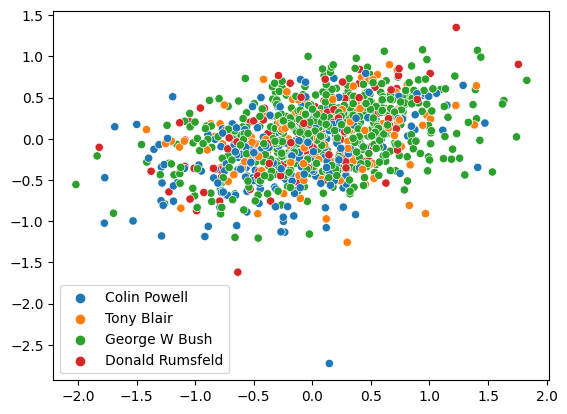

In [318]:
sns.scatterplot(x=proj_faces[:, 0], y=proj_faces[:, 1], hue=target_names[y])

### Using the projected faces we can train a classification model for faces

In [319]:
X_train, X_test, y_train, y_test = train_test_split(proj_faces, y, test_size=0.2, random_state=42)
X_train.shape

(824, 150)

### Train a Support Vector Machine (SVM) classifier

In [321]:
clf = SVC(kernel='rbf', probability=True)

gamma_range = [1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]
param_grid = dict(gamma=gamma_range, C=c_range)

grid = RandomizedSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print(f'Best Parameters: {grid.best_params_}\n')
svm = grid.best_estimator_

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Evaluate the classification performance
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

Best Parameters: {'gamma': 1e-05, 'C': 10000.0}

                 precision    recall  f1-score   support

   Colin Powell       0.77      0.74      0.76        46
Donald Rumsfeld       0.83      0.73      0.78        26
  George W Bush       0.87      0.89      0.88       109
     Tony Blair       0.83      0.92      0.87        26

       accuracy                           0.84       207
      macro avg       0.83      0.82      0.82       207
   weighted avg       0.84      0.84      0.84       207



## Spontaneous behaviors drive multidimensional, brainwide activity - Stringer et al. (2019)

Much previous work has linked spontaneous neural activity to behavior through one-dimensional measures like running speed and pupil diameter. However, mice perform diverse behaviors consisting of whisking, licking, sniffing, and other facial movements. We hypothesized that there exists a multidimensional representation of behavior in visual cortex and that previously reported “noise” during stimulus presentations may in fact be behaviorally driven.

Dataset:
https://figshare.com/articles/dataset/Recordings_of_ten_thousand_neurons_in_visual_cortex_during_spontaneous_behaviors/6163622

In [2]:
m = loadmat('spont_M160907_MP028_2016-09-26.mat')

In [3]:
spikes = m['Fsp']  # a matrix of size number of neurons by number of timepoints of deconvolved fluorescence traces.

# remove interneurons
redcell_idx = np.vstack(m['stat']['redcell'].squeeze()).squeeze().astype(bool)
spikes = spikes[~redcell_idx, :]
spikes.shape

(8706, 10301)

In [4]:
%%time
X_centered = spikes.T - np.mean(spikes.T, axis=0)

# Perform SVD on the centered data
U, S, Vt = np.linalg.svd(X_centered, full_matrices=True)
print(f'U: {U.shape}')
print(f'S: {S.shape}')
print(f'Vt: {Vt.shape}')

U: (10301, 10301)
S: (8706,)
Vt: (8706, 8706)
CPU times: user 44min 10s, sys: 1min 54s, total: 46min 4s
Wall time: 6min 9s


In [22]:
n_components = 200
spikes_pcs = np.matmul(X_centered, Vt[:, :n_components])
spikes_pcs.shape

(10301, 200)

In [6]:
faces = m['beh']['face'][0, 0]
face_motion_svd = zscore(-faces['motionSVD'][0, 0])  # temporal traces of the SVDs (1000), sampled at the times of the neural frames
face_motion_mask = faces['motionMask'][0, 0]  # spatial masks of the SVDs (1000).
face_motion_svd.shape

(10301, 1000)

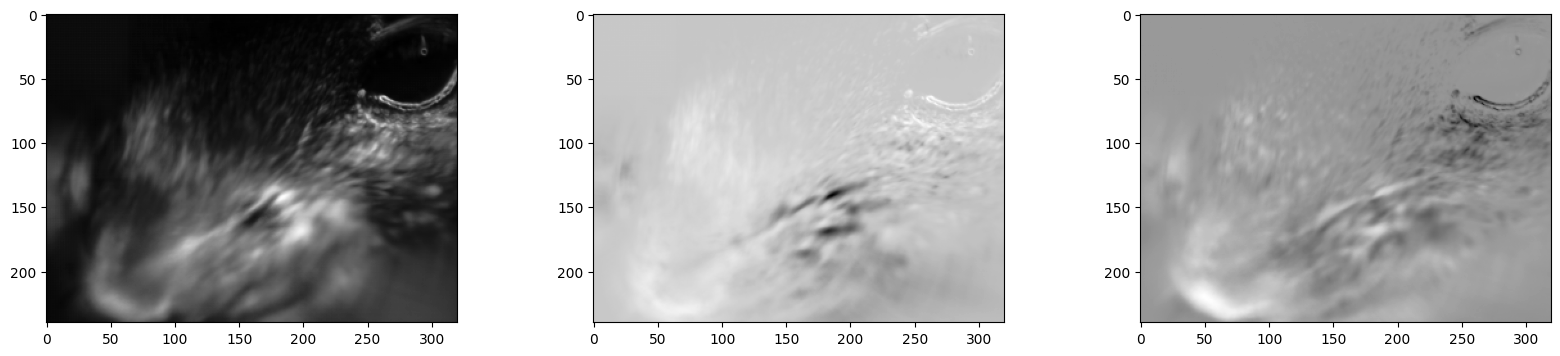

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for i in range(3):
    img = face_motion_mask[:, :, i]
    axes[i].imshow(img, cmap='Greys')

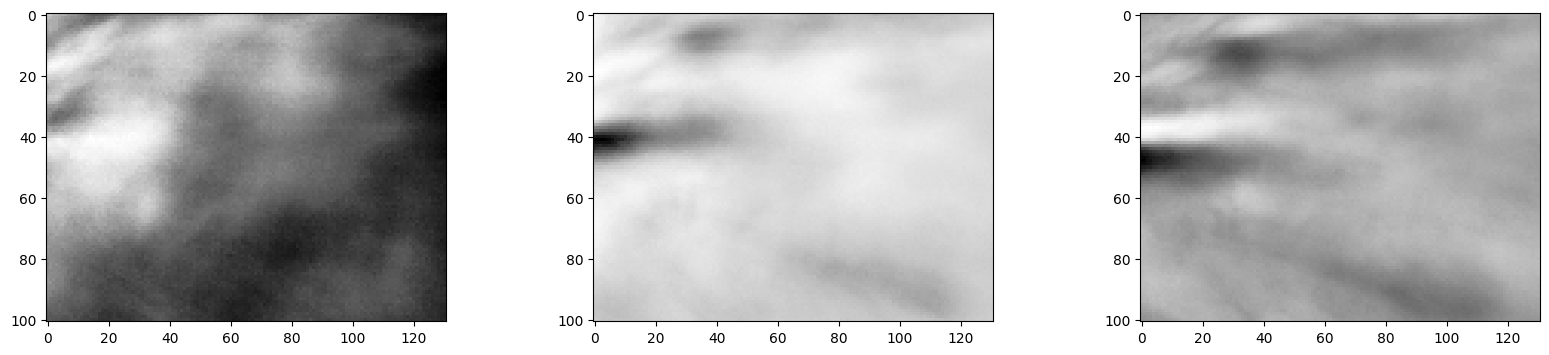

In [8]:
whisker_motion_mask = m['beh'][0, 0]['whisker'][0, 0]['motionMask']
whisker_motion_svd = zscore(-m['beh'][0, 0]['whisker'][0, 0]['motionSVD'])

fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for i in range(3):
    img = whisker_motion_mask[:, :, i]
    axes[i].imshow(img, cmap='Greys')

### 1D behavioral metrics

In [9]:
running_speed = zscore(m['beh']['runSpeed'][0, 0].squeeze())
pupil_area = zscore(m['beh']['pupil'][0, 0]['area'][0, 0].squeeze())

## Correlations

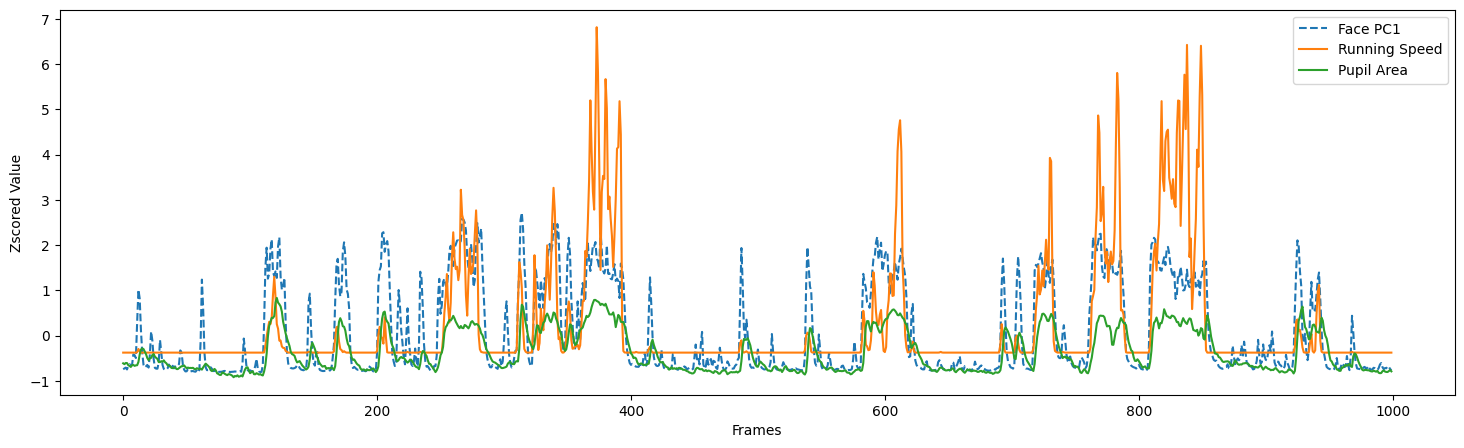

In [10]:
n = 1000
plt.figure(figsize=(18, 5))
plt.plot(face_motion_svd[:n, 0], '--', label='Face PC1')
plt.plot(running_speed[:n], label='Running Speed')
plt.plot(pupil_area[:n], label='Pupil Area')
plt.xlabel('Frames')
plt.ylabel('Zscored Value')
plt.legend()
plt.show()

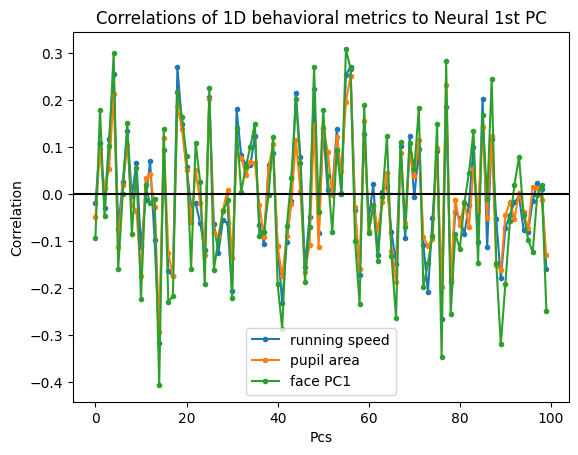

In [23]:
for metric_name, metric in {'running speed': running_speed, 'pupil area': pupil_area, 'face PC1': face_motion_svd[:, 0]}.items():
    c = []
    for i in range(100):
        c.append(np.corrcoef(spikes_pcs[:, i], metric)[0, 1])
    plt.plot(c, '.-', label=metric_name)
plt.axhline(0, c='k')
plt.title('Correlations of 1D behavioral metrics to Neural 1st PC')
plt.xlabel('Pcs')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### Predict Neural Activity using behavioral PCs

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

reg = DecisionTreeRegressor()

In [31]:
X = zscore(face_motion_svd.copy())
y = zscore(spikes_pcs.copy())
y.shape

(10301, 200)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(8240, 1000)

In [33]:
%%time
reg.fit(X_train, y_train)

CPU times: user 1min 46s, sys: 75.1 ms, total: 1min 46s
Wall time: 1min 46s


DecisionTreeRegressor()

In [34]:
# Make predictions on the test data
y_pred = reg.predict(X_test)


Overall MSE: 1.8401712318007182


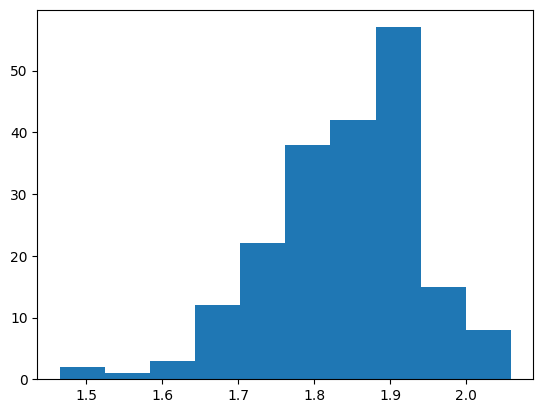

In [36]:
# Calculate mean squared error (MSE) for each output
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Print the MSE for each output as histogram
plt.hist(mse)

# Calculate overall mean squared error (MSE)
overall_mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
print(f"\nOverall MSE: {overall_mse}")

### Paper's Plotrunning_speed

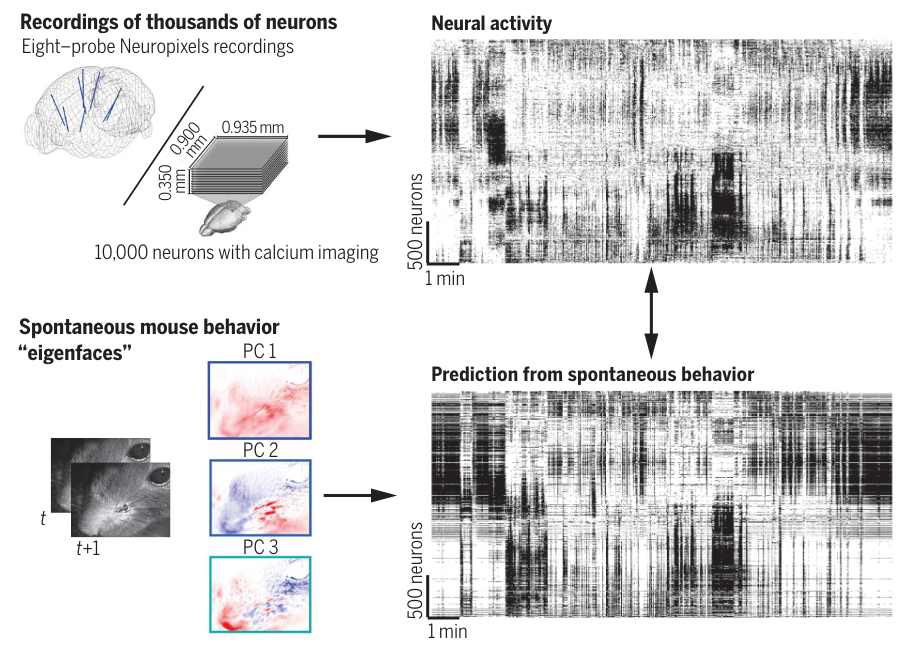